In [1]:
import numpy as np
from sklearn.datasets import fetch_openml

mnist = fetch_openml("mnist_784",version =1)

In [2]:
X = mnist.data
y = mnist.target
y = y.astype(np.uint8) # ! remember that target column is str



X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

y_train_5 = (y_train == 5) # True for all 5s, False for all other digits.
y_test_5 = (y_test == 5)

In [3]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3,random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [4]:
from sklearn.model_selection import cross_val_predict
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [5]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

####  above is pretty much all we need from previous notebooks

### ROC Curve - receiver operating characteristic 
    - It is very similar to the precision/recall curve, but instead of plotting precision versus       recall, the ROC curve plots the true positive rate  TPR (another name for recall) against the false positive rate FPR.
    - The true positive rate is the proportion of observations that were correctly predicted to be positive out of all positive observations (TP/(TP + FN))
    -  The false positive rate is the proportion of observations that are incorrectly predicted to be positive out of all negative observations (FP/(TN + FP))
    
    
## To plot the ROC curve, you first need to compute the TPR and FPR for various threshold values, using the roc_curve() function

In [6]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

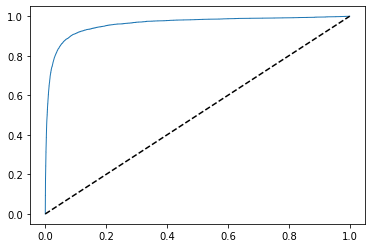

In [10]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt


def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=1, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal

plot_roc_curve(fpr, tpr)
plt.show()

### Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. The dotted line represents the ROC curve of a purely random classifier; a good classifier stays as far away from that line as possible (toward the top-left corner).

# How to interpret 

    - first lets see again what is sensitivity / specificity  and FPR thinks that will help use interpret the ROC:
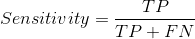
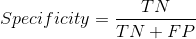
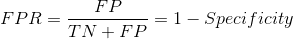
    
Let's see a dummy chart and try to interpret:
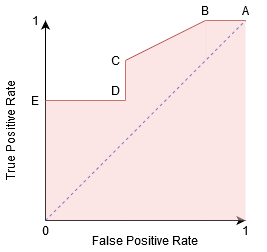

- Point A is where the Sensitivity is the highest and Specificity the lowest. This means all the Positive class points are classified correctly and all the Negative class points are classified incorrectly.

- Although Point B has the same Sensitivity as Point A, it has a higher Specificity. Meaning the number of incorrectly Negative class points is lower compared to the previous threshold. This indicates that this threshold is better than the previous one.   Specificity = 1 - FPR = 0.8

- Point C has a 0.8   TPR/Sensitivity   ;  FPR = 0.4  ; Specificity= 1 - FPR = 0.6
- Point D has 0.6 TPR/Sensitivity  ' FPR = 0.4  ; Specificity = 1- FPR = 0.6   , we can see that threshold at point C has a higher sensitivity at the same specificity , obviosly point C is better
    
    
So by this logic we can see that the perfect classifier would lie in the top-left corner of the ROC graph;

### !! One way to compare classifiers is to measure the area under the curve (AUC).
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_auc_score.html

In [13]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

### Interpretation:
    - When AUC = 1, then the classifier is able to perfectly distinguish between all the Positive and the Negative class points correctly. If, however, the AUC had been 0, then the classifier would be predicting all Negatives as Positives, and all Positives as Negatives. 
    - When 0.5<AUC<1, there is a high chance that the classifier will be able to distinguish the positive class values from the negative class values. This is so because the classifier is able to detect more numbers of True positives and True negatives than False negatives and False positives.
    - When AUC=0.5, then the classifier is not able to distinguish between Positive and Negative class points. Meaning either the classifier is predicting random class or constant class for all the data points.

So, the higher the AUC value for a classifier, the better its ability to distinguish between positive and negative classes.

#### !!!  

Since the ROC curve is so similar to the precision/recall (or PR)
curve, you may wonder how to decide which one to use. As a rule
of thumb, you should *prefer the PR curve whenever the positive
class is rare or when you care more about the false positives than
the false negatives*, and the ROC curve otherwise. For example,
looking at the previous ROC curve (and the ROC AUC score), you
may think that the classifier is really good. But this is mostly
because there are few positives (5s) compared to the negatives
(non-5s). In contrast, the **PR curve (see notebook 05)** makes it clear that the classifier
has room for improvement (the curve could be closer to the topright
corner).

In [14]:
# in the book they train a RandomForestClassifier and compares it to SGDClassifier  
# both the ROC and ROC AUC score
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,method="predict_proba")


###  RandomForestClassifier class does not have a decision_function() method. Instead it has a predict_proba() method. Scikit-Learn classifiers generally have one or the other.

predict_proba method returns an array containing the probability that a given instance (row) belongs to the given class (column)

In [17]:
import pandas as pd
return_predict_proba = pd.DataFrame(y_probas_forest,columns=["Probability NOT 5","Probability IS 5"])

In [20]:
return_predict_proba.head()

,Probability NOT 5,Probability IS 5
0,0.11,0.89
1,0.99,0.01
2,0.96,0.04
3,1.00,0.00
4,0.99,0.01


In [22]:
y_scores_forest = y_probas_forest[:, 1]  #use the positive class probability as score for roc_curve 
y_scores_forest

array([0.89, 0.01, 0.04, ..., 0.98, 0.08, 0.06])

In [23]:
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

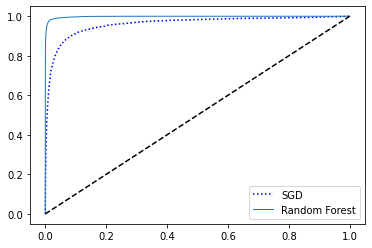

In [24]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

### as we can see RandomForestClassifier's ROC curve goes to the left-top corner much closer that SGD , let's check the AUC score:

In [25]:
roc_auc_score(y_train_5, y_scores_forest)  #much better

0.9983436731328145

In [29]:
#let's check the precision and recall scores like they ask us in the book

from sklearn.metrics import precision_score, recall_score

y_pred_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3)
precision_score(y_train_5,y_pred_forest), recall_score(y_train_5,y_pred_forest)

(0.9905083315756169, 0.8662608374838591)